In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

import operator
import matplotlib.pyplot as plt

import isolearn.io as isoio


def sort_and_balance_library(library_dict, included_libs=None, count_filter_dict=None) :
    
    #Filter on read count
    print('Library size before count filtering = ' + str(len(library_dict['data'])))
    
    if count_filter_dict is not None :
        included_index = []
        for index, row in library_dict['data'].iterrows() :
            if row['library_index'] not in count_filter_dict :
                included_index.append(index)
            elif row['total_count'] >= count_filter_dict[row['library_index']] :
                included_index.append(index)
        
        library_dict['data'] = library_dict['data'].iloc[included_index].reset_index(drop=True)
        library_dict['cuts'] = library_dict['cuts'][included_index]
    
    print('Library size after count filtering = ' + str(len(library_dict['data'])))
    
    #Sort and balance library dataframe and cut matrix
    
    L_included = included_libs
    
    arranged_index_len = 0
    
    arranged_index_len = int(np.sum([len(np.nonzero(library_dict['data']['library_index'] == lib)[0]) for lib in L_included]))
    min_join_len = int(np.min([len(np.nonzero(library_dict['data']['library_index'] == lib)[0]) for lib in L_included]))
    
    arranged_index = np.zeros(arranged_index_len, dtype=np.int)

    arranged_remainder_index = 0
    arranged_join_index = arranged_index_len - len(L_included) * min_join_len

    for lib_i in range(0, len(L_included)) :
        lib = L_included[lib_i]

        print('Arranging lib ' + str(lib))

        #1. Get indexes of each Library
        lib_index = np.nonzero(library_dict['data']['library_index'] == lib)[0]
        
        #2. Sort indexes of each library by count
        lib_count = library_dict['data'].iloc[lib_index]['total_count']
        sort_index_lib = np.argsort(lib_count)
        lib_index = lib_index[sort_index_lib]
        
        #3. Shuffle indexes of each library modulo 2
        even_index_lib = np.nonzero(np.arange(len(lib_index)) % 2 == 0)[0]
        odd_index_lib = np.nonzero(np.arange(len(lib_index)) % 2 == 1)[0]

        lib_index_even = lib_index[even_index_lib]
        lib_index_odd = lib_index[odd_index_lib]

        lib_index = np.concatenate([lib_index_even, lib_index_odd])

        #4. Join modulo 2
        i = 0
        for j in range(len(lib_index) - min_join_len, len(lib_index)) :
            arranged_index[arranged_join_index + i * len(L_included) + lib_i] = lib_index[j]
            i += 1

        #5. Append remainder
        for j in range(0, len(lib_index) - min_join_len) :
            arranged_index[arranged_remainder_index] = lib_index[j]
            arranged_remainder_index += 1
    
    library_dict['data'] = library_dict['data'].iloc[arranged_index].reset_index(drop=True)
    library_dict['cuts'] = library_dict['cuts'][arranged_index]
    
    print('Done sorting library.')
    
    return library_dict

def plot_cut_2mers(datafr, cut_mat) :
    cut_mer2 = {}

    seqs = list(datafr['seq'].values)
    seqs = np.array(seqs, dtype=np.object)

    total_count = np.array(datafr['total_count'])

    cx = sp.coo_matrix(cut_mat)

    for i,j,v in zip(cx.row, cx.col, cx.data) :
        seq = seqs[i]

        #mer2 = seq[j-1:j+1]
        mer2 = seq[j:j+2]
        if mer2 not in cut_mer2 :
            cut_mer2[mer2] = 0
        cut_mer2[mer2] += v

    cut_mer2_sorted = sorted(cut_mer2.items(), key=operator.itemgetter(1))

    mer2_list = []
    mer2_vals = []
    for i in range(0, len(cut_mer2_sorted)) :
        mer2_list.append(cut_mer2_sorted[i][0])
        mer2_vals.append(cut_mer2_sorted[i][1])

    f = plt.figure(figsize=(6, 4))

    plt.bar(mer2_list, mer2_vals, color='black')

    plt.title('Proximal cleavage dinuc.', fontsize=14)
    plt.xlabel('Dinucleotide', fontsize=14)
    plt.ylabel('Read count', fontsize=14)

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

In [2]:
#Read legacy library data frame and cut matrix

iso_df = pd.read_csv('processed_data_legacy/apa_general3_antimisprime_orig.csv', sep=',')

cut_df = pd.read_csv('processed_data_legacy/apa_general_cuts_antimisprime_orig.csv', sep=',')
cut_mat = spio.loadmat('processed_data_legacy/apa_general_cuts_antimisprime_orig_cutdistribution.mat')['cuts']


In [3]:
iso_df = iso_df.drop(columns=['total_count_vs_distal', 'proximal_avgcut', 'proximal_stdcut'])
iso_df = iso_df.rename(columns={'total_count_vs_all' : 'total_count'})
iso_df = iso_df.copy().set_index('seq')

cut_df['row_index_cuts'] = np.arange(len(cut_df), dtype=np.int)
cut_df = cut_df[['seq', 'total_count', 'row_index_cuts']].copy().set_index('seq')

In [4]:
joined_df = iso_df.join(cut_df, how='inner', rsuffix='_cuts')
joined_cuts = cut_mat[np.ravel(joined_df['row_index_cuts'].values), :]
joined_df = joined_df.drop(columns=['row_index_cuts']).copy().reset_index()

joined_df = joined_df.rename(columns={'library' : 'library_index', 'library_name' : 'library'})

print(len(joined_df))
print(joined_cuts.shape)

print(joined_df.head())

3338181
(3338181, 186)
                                                 seq  \
0  CTGCTTGTTAAGAACAAGTTTGGCTATCCGTAACGGAGAGTACGCC...   
1  CTGCTATGAGACTGGGTAGCGGTTGCTGGTAACTGACCTTCAAAGC...   
2  CTGCTTGTTAAGAACAAGTTTGGCTAGTTGGAGTCTCCGCTAGTTC...   
3  CTGCTACAGTGCGATGTTCTTGAAACTGGTAACTGACCTTCAAAGC...   
4  CTGCTTGTTAAGAACAAGTTTGGCTACAGACAAGGTCCACCCAACC...   

                                             seq_ext  proximal_count  \
0  GCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGAT...               7   
1  GCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGAT...               8   
2  GCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGAT...               1   
3  GCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGAT...               0   
4  GCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGAT...               1   

   total_count  library_index                  library  total_count_cuts  
0           12              5  TOMM5_UPWT20N20_DN_WT20                12  
1           12              2  TOMM5_UPN20WT20_DN_WT20   

In [5]:
#Sort library data

library_dict = sort_and_balance_library({'data' : joined_df, 'cuts' : joined_cuts}, included_libs=[2, 5, 8, 11, 20, 22, 30, 31, 32, 33, 34, 35])


Library size before count filtering = 3338181
Library size after count filtering = 3338181


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


Arranging lib 2
Arranging lib 5
Arranging lib 8
Arranging lib 11
Arranging lib 20
Arranging lib 22
Arranging lib 30
Arranging lib 31
Arranging lib 32
Arranging lib 33
Arranging lib 34
Arranging lib 35
Done sorting library.


In [6]:

print('Dataframe length = ' + str(len(library_dict['data'])))
print('Cut matrix size = ' + str(library_dict['cuts'].shape))


Dataframe length = 3323389
Cut matrix size = (3323389, 186)


In [7]:
#Check sublibrary counts in top readcount portion of library

libs = library_dict['data']['library'].unique()
total_size = len(library_dict['data'])
for lib in libs :
    lib_size = len(np.nonzero((library_dict['data']['library'] == lib))[0])
    
    print('len(' + lib + ') = ' + str(lib_size))


len(TOMM5_UPN20WT20_DN_WT20) = 204151
len(TOMM5_UPWT20N20_DN_WT20) = 216234
len(TOMM5_UPN20WT20_DN_N20) = 33304
len(TOMM5_UPWT20N20_DN_N20) = 165642
len(DoubleDope) = 602450
len(Simple) = 772347
len(ATR) = 201432
len(HSPE1) = 371995
len(SNHG6) = 447817
len(SOX13) = 126240
len(WHAMMP2) = 159424
len(AARS) = 22353


In [8]:
#Dump random MPRA dataframe and cut matrix

isoio.dump({'plasmid_df' : library_dict['data'], 'plasmid_cuts' : library_dict['cuts']}, 'processed_data_lifted/apa_plasmid_data_legacy')


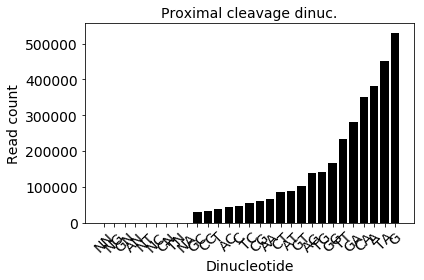

In [30]:
#Plot combined library cut dinucleotides

plot_cut_2mers(library_dict['data'], library_dict['cuts'])


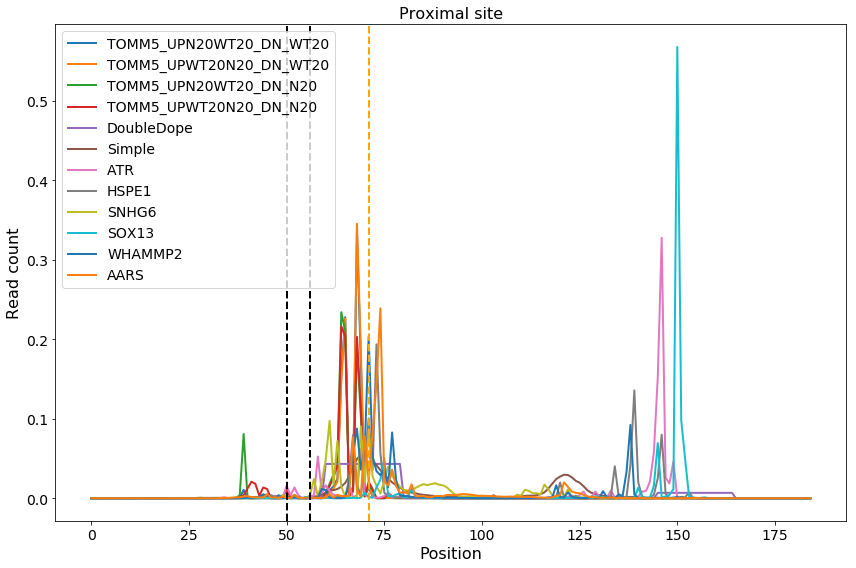

In [33]:
#Plot overlayed cut profiles

f = plt.figure(figsize=(12, 8))

libs = library_dict['data']['library'].unique()

ls = []
for lib in libs :
    
    lib_index = np.nonzero((library_dict['data']['library'] == lib))[0]
    lib_cut_probs = np.array(library_dict['cuts'][lib_index].todense())
    lib_cuts = lib_cut_probs * np.ravel(library_dict['data']['total_count'].values)[lib_index].reshape(-1, 1)
    proximal_profile = np.ravel(np.sum(lib_cuts, axis=0))[:-1]
    proximal_profile /= np.sum(proximal_profile)

    la, = plt.plot(np.arange(len(proximal_profile)), proximal_profile, linewidth=2, label=lib)
    ls.append(la)
    

#Proximal
plt.axvline(x=50, linewidth=2, c='black', linestyle='--')
plt.axvline(x=50 + 6, linewidth=2, c='black', linestyle='--')
plt.axvline(x=50 + 21, linewidth=2, c='orange', linestyle='--')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Read count', fontsize=16)
plt.title('Proximal site', fontsize=16)
plt.tight_layout()

plt.legend(handles = ls, fontsize=14)

plt.show()


In [37]:

#Check sublibrary counts in top readcount portion of library

from_fraction = 0.075

libs = library_dict['data']['library'].unique()
total_size = len(library_dict['data'])
for lib in libs :
    lib_slice = library_dict['data'].iloc[-int(from_fraction * total_size):]
    lib_size = len(np.nonzero((lib_slice['library'] == lib))[0])
    
    print('len(' + lib + ') = ' + str(lib_size))


len(TOMM5_UPN20WT20_DN_WT20) = 20771
len(TOMM5_UPWT20N20_DN_WT20) = 20771
len(TOMM5_UPN20WT20_DN_N20) = 20771
len(TOMM5_UPWT20N20_DN_N20) = 20771
len(DoubleDope) = 20771
len(Simple) = 20771
len(ATR) = 20771
len(HSPE1) = 20771
len(SNHG6) = 20771
len(SOX13) = 20772
len(WHAMMP2) = 20772
len(AARS) = 20771


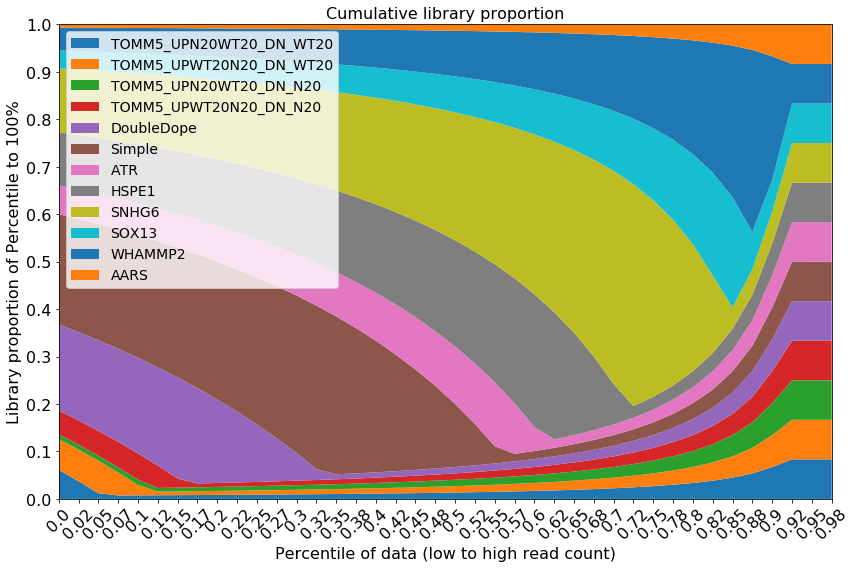

In [40]:
#Plot sublibrary cumulative proportions

library_fractions_from_top = np.linspace(0, 1, num=41)[1:]
libs = library_dict['data']['library'].unique()

cum_fraction = np.zeros((len(library_fractions_from_top), len(libs)))

total_lib_size = float(len(library_dict['data']))

frac_i = 0
for library_fraction in library_fractions_from_top :
    
    lib_i = 0
    for lib in libs :
        lib_slice = library_dict['data'].iloc[-int(library_fraction * total_lib_size):]
        
        lib_size = len(np.nonzero((lib_slice['library'] == lib))[0])
        
        curr_frac = float(lib_size) / float(len(lib_slice))
        
        cum_fraction[frac_i, lib_i] = curr_frac
        
        lib_i += 1
    
    frac_i += 1


fig = plt.subplots(figsize=(12, 8))

plt.stackplot(library_fractions_from_top, np.fliplr(cum_fraction.T), labels=libs)
plt.legend(loc='upper left', fontsize=14)

plt.xticks(library_fractions_from_top, np.flip(np.round(1.0 - library_fractions_from_top, 2), axis=0), fontsize=16, rotation=45)
plt.yticks(np.linspace(0, 1, num=10 + 1), np.round(np.linspace(0, 1, num=10 + 1), 2), fontsize=16)

plt.xlim(np.min(library_fractions_from_top), np.max(library_fractions_from_top))
plt.ylim(0, 1)

plt.xlabel('Percentile of data (low to high read count)', fontsize=16)
plt.ylabel('Library proportion of Percentile to 100%', fontsize=16)

plt.title('Cumulative library proportion', fontsize=16)

plt.tight_layout()
plt.show()

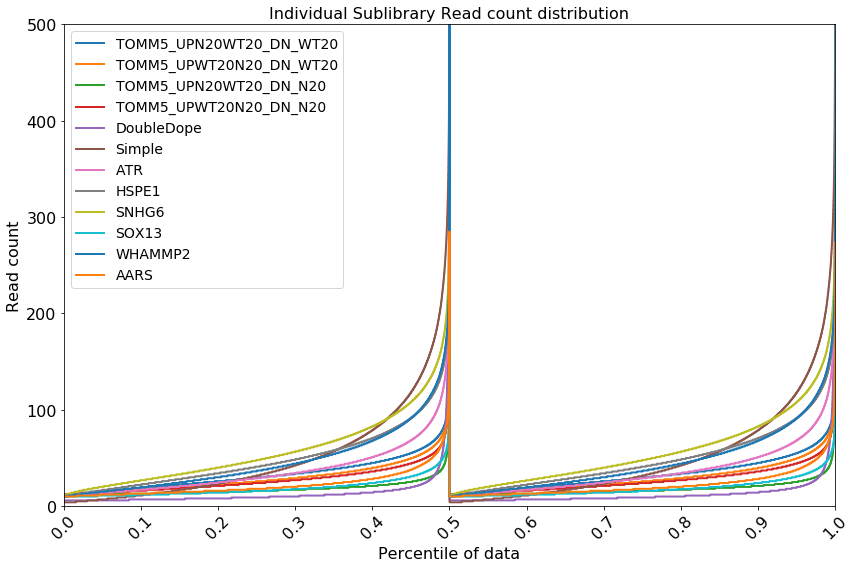

In [41]:

total_count = np.ravel(library_dict['data']['total_count'].values)

lib_frac = np.arange(total_count.shape[0]) / float(total_count.shape[0])

libs = library_dict['data']['library'].unique()

fig = plt.figure(figsize = (12, 8))
ls = []

for lib in libs :
    lib_index = np.nonzero(library_dict['data']['library'] == lib)[0]
    lib_slice = library_dict['data'].iloc[lib_index]
    
    lib_count = np.ravel(lib_slice['total_count'].values)
    lib_frac = np.arange(len(lib_slice)) / float(len(lib_slice))
    
    lt, = plt.plot(lib_frac, lib_count, linewidth=2, label=lib)
    ls.append(lt)

plt.legend(handles=ls, loc='upper left', fontsize=14)

plt.xticks(np.round(np.linspace(0, 1, num=10 + 1), 2), np.round(np.linspace(0, 1, num=10 + 1), 2), fontsize=16, rotation=45)
plt.yticks(fontsize=16)

plt.xlim(0, 1)
plt.ylim(0, 500)

plt.xlabel('Percentile of data', fontsize=16)
plt.ylabel('Read count', fontsize=16)

plt.title('Individual Sublibrary Read count distribution', fontsize=16)

plt.tight_layout()
plt.show()



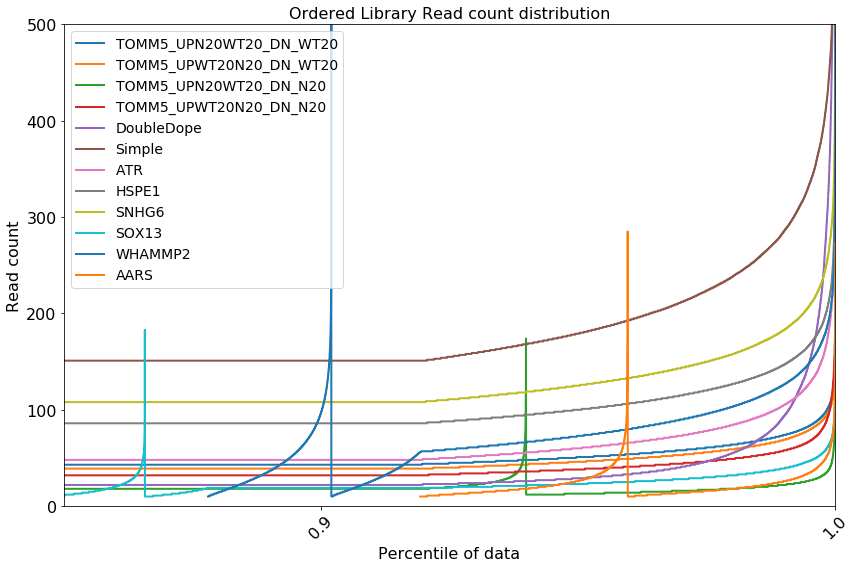

In [42]:

total_count = np.ravel(library_dict['data']['total_count'].values)

total_lib_frac = np.arange(total_count.shape[0]) / float(total_count.shape[0])

libs = library_dict['data']['library'].unique()

fig = plt.figure(figsize = (12, 8))
ls = []

for lib in libs :
    lib_index = np.nonzero(library_dict['data']['library'] == lib)[0]
    lib_slice = library_dict['data'].iloc[lib_index]
    
    lib_count = np.ravel(lib_slice['total_count'].values)
    lib_frac = total_lib_frac[lib_index]
    
    lt, = plt.plot(lib_frac, lib_count, linewidth=2, label=lib)
    ls.append(lt)

plt.legend(handles=ls, loc='upper left', fontsize=14)

plt.xticks(np.round(np.linspace(0, 1, num=10 + 1), 2), np.round(np.linspace(0, 1, num=10 + 1), 2), fontsize=16, rotation=45)
plt.yticks(fontsize=16)

plt.xlim(0.85, 1)
plt.ylim(0, 500)

plt.xlabel('Percentile of data', fontsize=16)
plt.ylabel('Read count', fontsize=16)

plt.title('Ordered Library Read count distribution', fontsize=16)

plt.tight_layout()
plt.show()

